In [33]:
import os
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import numpy as np

from pysoinn import util
from pysoinn import soinn_regression
from pysoinn.predictors import kNNDistanceWeightedRegressor

from random import randint, sample
from operator import itemgetter

import matplotlib.pyplot as plt

in_dir = 'D:\\Toppan\\2017-11-20 全データ\\処理済(総量)\\vectorized_keikaku_shibata'
files = [f for f in os.listdir(in_dir)]

# train and test data
#train_month_file, test_month_file = '201801010800.xlsx', '201802010800.xlsx'
train_month_file, test_month_file = '201701010800.xlsx', '201702010800.xlsx'

class ensemble_soinn():

    def __init__(self,
                 node_delete_interval_range,
                 max_edge_age_range,
                 n_neighbors_range,
                 shuffle=True,
                 n_estimators=10,
                 bootstrap=False,
                 normalized=False):

        self.node_delete_interval_range = node_delete_interval_range
        self.max_edge_age_range = max_edge_age_range
        self.n_neighbors_range = n_neighbors_range
        self.shuffle = shuffle
        self.n_estimators = n_estimators
        self.bootstrap = bootstrap
        self.normalized = normalized

        if self.normalized:
            self.normalizers_x = []
            self.normalizers_y = []

        self.estimators = []
        self.selected_feature_idxs = []


    def fit(self, X, y):
        n_features = X.shape[1]

        for i in range(self.n_estimators):

            # randomly select n (1 <= n <= total number of features) features for learning
            n_selected_features = randint(1, n_features)
            selected_feature_idx = sample(range(n_features), n_selected_features)

            # randomly select model parameters
            ndi = randint(self.node_delete_interval_range[0], self.node_delete_interval_range[1])
            mea = randint(self.max_edge_age_range[0], self.max_edge_age_range[1])
            nn = randint(self.n_neighbors_range[0], self.n_neighbors_range[1])

            # create model
            model = soinn_regression.SoiamRegression(
                node_delete_interval=ndi,
                max_edge_age=mea,
                predictor=kNNDistanceWeightedRegressor(n_neighbors=nn),
                shuffle=self.shuffle)

            # normalize
            if self.normalized:
                ss_x, ss_y = StandardScaler(), StandardScaler()

                x, y_ = ss_x.fit_transform(X[:, selected_feature_idx]), ss_y.fit_transform(y)

                self.normalizers_x.append(ss_x)
                self.normalizers_y.append(ss_y)
            else:
                x, y_ = X[:, selected_feature_idx], y

            # fit using selected features
            model.fit(x, y_)

            # append fitted models
            self.estimators.append(model)
            self.selected_feature_idxs.append(selected_feature_idx)

    def partial_fit(self):
        pass

    def predict(self, X):

        preds = []
        for x_ in X:

            preds_x = []
            for i, (estimator, selected_feature_idx) in enumerate(zip(self.estimators, self.selected_feature_idxs)):

                x = np.asarray(itemgetter(*selected_feature_idx)(x_)).reshape(1, -1)

                if self.normalized:
                    x = self.normalizers_x[i].transform(x)

                y = estimator.predict(x)

                if self.normalized:
                    y = self.normalizers_y[i].inverse_transform(y)

                if not np.isnan(y[0]):
                    preds_x.append(y[0])

            preds.append(np.mean(preds_x))

        return preds

def pred_energy(energy, train_month_file, test_month_file, n_estimators):
    # read data from file
    train_df = pd.read_excel(os.path.join(in_dir, train_month_file), sheet_name=energy).values
    test_df = pd.read_excel(os.path.join(in_dir, test_month_file), sheet_name=energy).values

    # split to x and y
    train_x, train_y = train_df[:-1, :-1], train_df[1:, -1].reshape(-1, 1)
    test_x, test_y = test_df[:-1, :-1], test_df[1:, -1].reshape(-1, 1)

    # model
    dtr = ensemble_soinn(
                n_estimators=n_estimators,
                node_delete_interval_range=[100, 500],
                max_edge_age_range=[100, 500],
                n_neighbors_range=[3, 15],
                shuffle=True,
                normalized=True)

    # fit
    dtr.fit(train_x, train_y)

    # predict
    pred_dtr = dtr.predict(test_x)

    # plot
    plt.figure(figsize=(20, 8))

    plt.plot(pred_dtr, label='pred')
    plt.plot(test_y, label='true')

    # plt.plot(pred_dtr - test_df[:, -1].ravel(), label='diff')

    print('mse: ', mean_squared_error(pred_dtr, test_y))

    plt.legend()


C:\Anaconda3\lib\site-packages\pysoinn\weighters.py:32: RuntimeWarning: divide by zero encountered in true_divide
  inv_values = 1.0 / (values + self.alpha)
C:\Anaconda3\lib\site-packages\pysoinn\weighters.py:38: RuntimeWarning: invalid value encountered in true_divide
  return (inv_values.T / scaling_factor).T


mse:  9.754592254600391


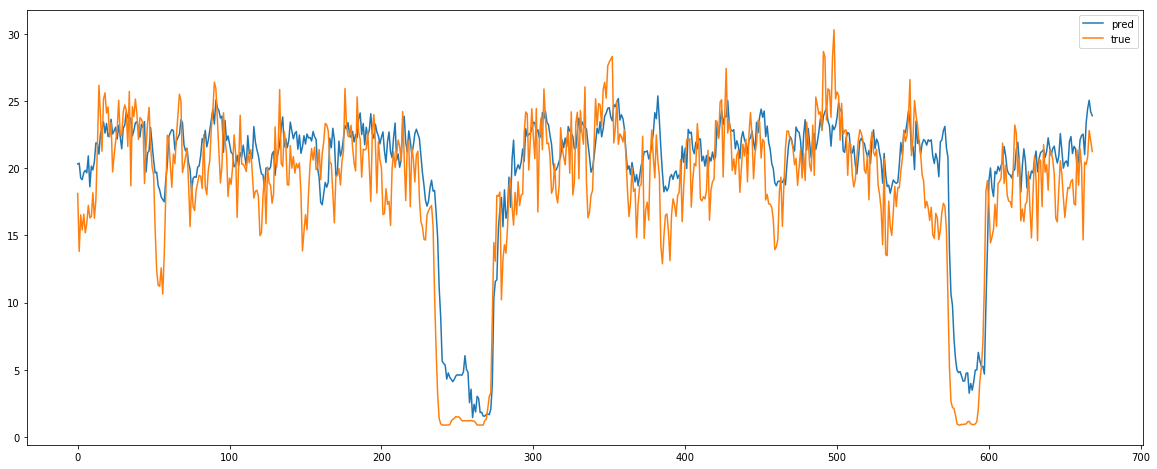

In [30]:
pred_energy('蒸気', train_month_file, test_month_file, 10)

In [ ]:
pred_energy('蒸気', train_month_file, test_month_file, 5000)

C:\Anaconda3\lib\site-packages\pysoinn\weighters.py:32: RuntimeWarning: divide by zero encountered in true_divide
  inv_values = 1.0 / (values + self.alpha)
C:\Anaconda3\lib\site-packages\pysoinn\weighters.py:38: RuntimeWarning: invalid value encountered in true_divide
  return (inv_values.T / scaling_factor).T


mse:  3.3151682575421892


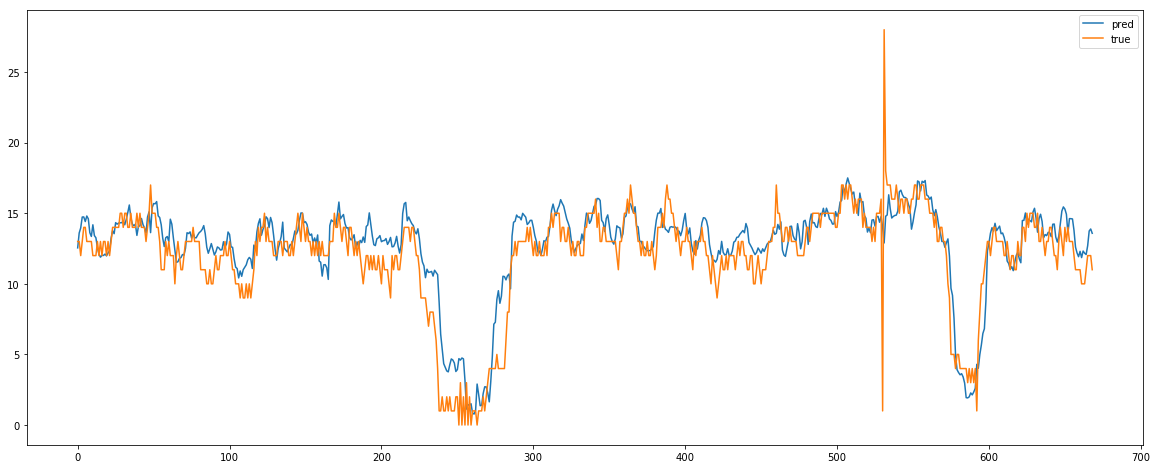

In [19]:
pred_energy('冷水', train_month_file, test_month_file, 100)

C:\Anaconda3\lib\site-packages\pysoinn\weighters.py:32: RuntimeWarning: divide by zero encountered in true_divide
  inv_values = 1.0 / (values + self.alpha)
C:\Anaconda3\lib\site-packages\pysoinn\weighters.py:38: RuntimeWarning: invalid value encountered in true_divide
  return (inv_values.T / scaling_factor).T


mse:  261002.07479733953


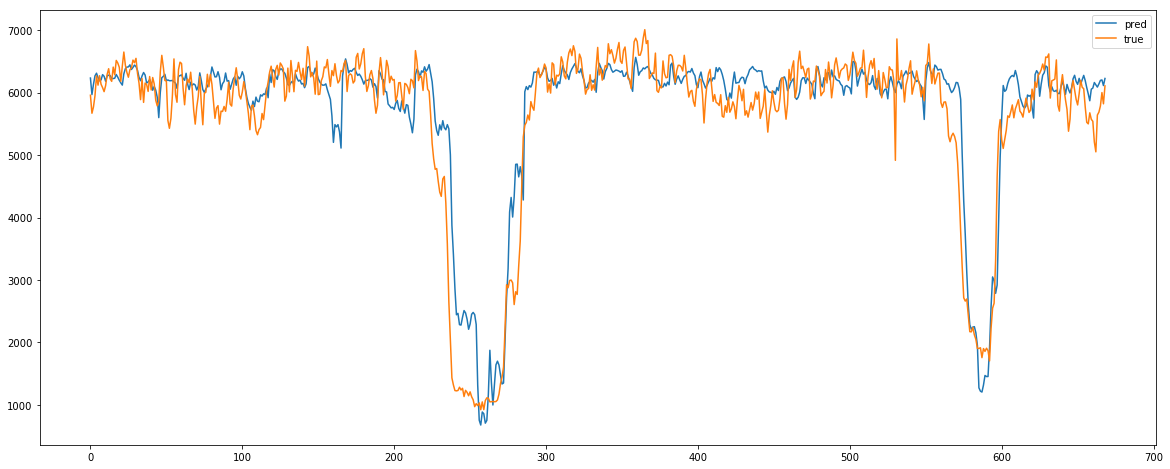

In [20]:
pred_energy('電力', train_month_file, test_month_file, 100)